In [1]:
%matplotlib inline

In [2]:
from __future__ import division
from __future__ import print_function

In [4]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy import ndimage
from scipy import stats
from scipy.spatial import distance

# K-Means clustering

K-Means is the most basic data clustering approach. Its operation consists of assigning each data sample to its *cluster* ensuring that samples added to a cluster are more similar to themselves than to the data in other clusters.

Alternatively, K-Means can be seen as a lossy compressions scheme, in which each sample is replaced with a prototype in a way that minimizes the total sum of errors.

Formally, given a set of $N$ data samples $X = \{x{(1)}, x^{(2)}, \ldots, x^{(N)}\}$ and a desired number of clusters $K$ K-Means finds $K$ cluster *centroids* or *prototypes* $\{\mu^{(j)}, j\in 1,2,\ldots,K\}$. Then, it assigns each sample $x^{(i)}$ to the cluster $c^{(i)} \in \{1, 2, \ldots, K\}$ whose centroids is the closest to $x^{(i)}$: $c^{(i)} = \underset{j}\arg\min ||x^{(i)} - \mu^{(j)}||$. To find the centroids, K-means attempts to solve the following optimization problem:

\begin{equation}
    \underset{\mu, c}\arg\min \sum_i||x^{(i)} - \mu^{(j)}||^2_2
\end{equation}

A typical algorithm used to solve the optimization problem iterates between optimizing over $\mu$ and optimizing over $c$:

- Initialize $\mu$ to e.g. K randomly selected data samples
- Loop:
    - Assign samples to clusters (optimize over $c$)
    - Move cluster centroids (optimize over $\mu$): $\mu^{(j)} \gets \frac{\sum_i [c^{(i)}=j] x^{(i)}}{\sum_i [c^{(i)}=j]}$, where $[]$ is the indicator function.
    
The code below applies the K-Means algorithm to optimize the color palette of an image. It replaces each 16-bit pixel (two 8-bit colors) by a 4-bit color identifier.

DEBUG:PIL.PngImagePlugin:STREAM IHDR 16 13
DEBUG:PIL.PngImagePlugin:STREAM pHYs 41 9
DEBUG:PIL.PngImagePlugin:STREAM gAMA 62 4
DEBUG:PIL.PngImagePlugin:STREAM cHRM 78 32
DEBUG:PIL.PngImagePlugin:cHRM 78 32 (unknown)
DEBUG:PIL.PngImagePlugin:STREAM IDAT 122 70981


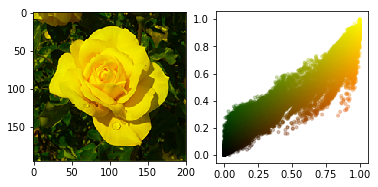

In [5]:
img = ndimage.io.imread('11-Rosa_Gold_Glow_2_small_noblue.png')/255.

plt.subplot(121)
plt.imshow(img)

im_flat = img.reshape([-1, 3])
plt.subplot(122)
plt.scatter(im_flat[:,0], im_flat[:,1], c=im_flat, marker='.', edgecolors='face', alpha=0.3)
plt.axis('square')
None

In [6]:
# use K-means to quantize the colors

In [7]:
N, D = im_flat.shape

Iteration: 0 Loss: 122.65
Iteration: 10 Loss: 82.8551
Iteration: 20 Loss: 76.9819
Iteration: 30 Loss: 74.7987
Iteration: 40 Loss: 74.0061
Iteration: 50 Loss: 73.492
Iteration: 60 Loss: 73.0547
Iteration: 70 Loss: 72.9568


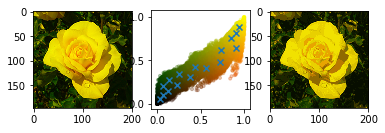

In [8]:
K = 16
initiali_center_ids = np.random.choice(N, (K,), replace=False)
centers = im_flat[initiali_center_ids, :]

old_loss = np.inf
for i in range(10000):
    center_to_cluster_dists = distance.cdist(centers, im_flat)
    cluster_assignment = np.argmin(center_to_cluster_dists, axis=0)
    for k in xrange(K):
        centers[k] = im_flat[cluster_assignment==k].mean(axis=0)
    loss = ((centers[cluster_assignment] - im_flat)**2).sum()
    if not i%10:
        print ("Iteration: %d Loss: %g" % (i, loss))
    if loss >= old_loss:
        break
    old_loss = loss

plt.subplot(131)
plt.imshow(img)

plt.subplot(132)
plt.scatter(im_flat[:,0], im_flat[:,1], c=im_flat, marker='.', edgecolors='face', alpha=0.3)
plt.scatter(centers[:,0], centers[:,1], marker='x')
plt.axis('square')

plt.subplot(133)
center_to_cluster_dists = distance.cdist(centers, im_flat)
cluster_assignment = np.argmin(center_to_cluster_dists, axis=0)
plt.imshow(centers[cluster_assignment].reshape(img.shape))

# On-line K-means

The default K-means algorithm works in batch mode: all data samples are processed at each iteration. We can, however simply transform k-means to an on-line algorithm. The main idea is to process a stream of data samples. For each sample, we find its closest centroid and move it in the direction of the sample by a small amount. This is called **winner takes all** approach: the winning (closest) centroid takes all the update.

The code below recreates the compression example using on-line training.

Iteration: 0 Loss: 212.992
Iteration: 100000 Loss: 96.0581
Iteration: 200000 Loss: 80.9474
Iteration: 300000 Loss: 79.6923
Iteration: 400000 Loss: 78.5751
Iteration: 500000 Loss: 78.0781
Iteration: 600000 Loss: 78.0721
Iteration: 700000 Loss: 77.1482
Iteration: 800000 Loss: 74.9927
Iteration: 900000 Loss: 74.9268


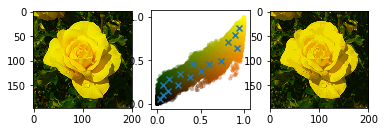

In [11]:
# An on-line version of k-Means

K = 16
initiali_center_ids = np.random.choice(N, (K,), replace=False)
centers = im_flat[initiali_center_ids, :]

alpha = 1e-2
for i in range(1000000):
    sampled_x = im_flat[np.random.randint(N)]
    cluster_id = np.argmin(((centers - sampled_x)**2).sum(axis=1))
    centers[cluster_id] = (1 - alpha) * centers[cluster_id] + alpha * sampled_x
    
    if not i%100000:
        center_to_cluster_dists = distance.cdist(centers, im_flat)
        cluster_assignment = np.argmin(center_to_cluster_dists, axis=0)
        loss = ((centers[cluster_assignment] - im_flat)**2).sum()
        print ("Iteration: %d Loss: %g" % (i, loss))
    
plt.subplot(131)
plt.imshow(img)

plt.subplot(132)
plt.scatter(im_flat[:,0], im_flat[:,1], c=im_flat, marker='.', edgecolors='face', alpha=0.3)
plt.scatter(centers[:,0], centers[:,1], marker='x')
plt.axis('square')

plt.subplot(133)
center_to_cluster_dists = distance.cdist(centers, im_flat)
cluster_assignment = np.argmin(center_to_cluster_dists, axis=0)
plt.imshow(centers[cluster_assignment].reshape(img.shape))

# Kohonen maps

The on-line *winner takes all* approach yields yet another generalization: **winner takes most**. In the very successful Kohonen map data representation we define a neighborhood relation (a topology) on the centroids. Then, we change a centroid *and its neighbors*. Please note that the topology is chosen a-priori, without seeing any data.

In the example below, the topology is a linear one: the centroids are arranged into a chain and we define matrix $C$ to control which centroids are changed during algorithm iterations.

In the code given below, for each data sample the closest centroid is found. Then, we look at its neighborhood and change all the centroids, proportionally to the appropriate row of the *C* matrix.

Typically, when the algorithm finishes the chain of centorids spans all colors and movement along it roughly corresponds to pixel intensity changes. Thus, the map has found a nonlinear, 1D representation of the data (the pixel intensities).

There are many more variations of the self organizing map, you can play with demos for several ones here: http://www.demogng.de/js/demogng.html?model=GNG&showAutoRestart&autoRestartTime=8

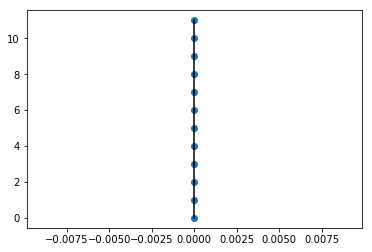

In [27]:
# Kohonen map

# First create a topology between units.
# This has nothing to do with the data we want to quantize!

NY, NX = np.meshgrid(np.arange(1), np.arange(12))
neuron_topology = np.stack([NY.ravel(), NX.ravel()], axis=1)

K = neuron_topology.shape[0]

C = np.zeros((K, K))
for ni in xrange(K):
    for nj in xrange(K):
        C[ni, nj] = np.maximum(0.0, 
                               1.0 - np.abs(neuron_topology[ni] - neuron_topology[nj]).sum()/2.0)

def plot_lines(C, locations, **kwargs):
    segments = []
    for ni, nj in zip(*np.nonzero(C)):
        if ni < nj:
            segments.append(locations[ni])
            segments.append(locations[nj])
            segments.append(np.zeros((2,)) + np.nan)
    segments = np.array(segments)
    plt.plot(segments[:,0], segments[:,1], **kwargs)

plt.scatter(neuron_topology[:,0], neuron_topology[:,1])
plot_lines(C, neuron_topology, color='k')

In [28]:
C

Shape: (12, 12)
[[ 1.   0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.5  1.   0.5  0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.5  1.   0.5  0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.5  1.   0.5  0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.5  1.   0.5  0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.5  1.   0.5  0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.5  1.   0.5  0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.5  1.   0.5  0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.5  1.   0.5  0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.5  1.   0.5  0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.5  1.   0.5]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.5  1. ]]

In [ ]:
# Kohonen map

# First create a topology between units.
# This has nothing to do with the data we want to quantize!

initiali_center_ids = np.random.choice(N, (K,), replace=False)
centers = im_flat[initiali_center_ids, :]

alpha = 2e-2
for i in range(3000000):
    sampled_x = im_flat[np.random.randint(N)]
    cluster_id = np.argmin(((centers - sampled_x)**2).sum(axis=1))
    cluster_alpha = (alpha * C[cluster_id]).reshape([-1, 1])
    centers = (1 - cluster_alpha) * centers + cluster_alpha * sampled_x
    
    if not i%100000:
        center_to_cluster_dists = distance.cdist(centers, im_flat)
        cluster_assignment = np.argmin(center_to_cluster_dists, axis=0)
        loss = ((centers[cluster_assignment] - im_flat)**2).sum()
        print ("Iteration: %d Loss: %g" % (i, loss))
    
plt.subplot(131)
plt.imshow(img)

plt.subplot(132)
plt.scatter(im_flat[:,0], im_flat[:,1], c=im_flat, marker='.', edgecolors='face', alpha=0.3)
plt.scatter(centers[:,0], centers[:,1], marker='x')
plot_lines(C, centers[:,:2], color='k')
plt.axis('square')

plt.subplot(133)
center_to_cluster_dists = distance.cdist(centers, im_flat)
cluster_assignment = np.argmin(center_to_cluster_dists, axis=0)
plt.imshow(centers[cluster_assignment].reshape(img.shape))

Iteration: 0 Loss: 247.64
Iteration: 100000 Loss: 110.557
Iteration: 200000 Loss: 108.167
Iteration: 300000 Loss: 110.496
Iteration: 400000 Loss: 109.618
Iteration: 500000 Loss: 109.064
Iteration: 600000 Loss: 108.481
Iteration: 700000 Loss: 109.832
Iteration: 800000 Loss: 109.052
Iteration: 900000 Loss: 109.753
Iteration: 1000000 Loss: 109.464
Iteration: 1100000 Loss: 108.769
Iteration: 1200000 Loss: 108.354
Iteration: 1300000 Loss: 107.474
Iteration: 1400000 Loss: 110.644
Iteration: 1500000 Loss: 108.533
Iteration: 1600000 Loss: 111.951
Iteration: 1700000 Loss: 110.069
Iteration: 1800000 Loss: 111.152
Iteration: 1900000 Loss: 109.094
Iteration: 2000000 Loss: 111.627
Iteration: 2100000 Loss: 106.759
Iteration: 2200000 Loss: 108.53
Iteration: 2300000 Loss: 107.603
Iteration: 2400000 Loss: 111.491
Iteration: 2500000 Loss: 109.104
Iteration: 2600000 Loss: 109.061
Iteration: 2700000 Loss: 106.482
Iteration: 2800000 Loss: 110.915
Iteration: 2900000 Loss: 109.84


(-0.054928315412186395,
 1.0602482850293145,
 -0.057588300220750559,
 1.0575883002207505)

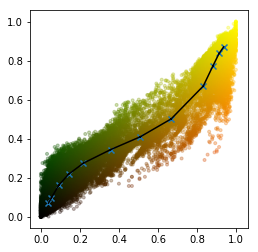

In [20]:
plt.scatter(im_flat[:,0], im_flat[:,1], c=im_flat, marker='.', edgecolors='face', alpha=0.3)
plt.scatter(centers[:,0], centers[:,1], marker='x')
plot_lines(C, centers[:,:2], color='k')
plt.axis('square')

# Fitting a Gaussian mixture using EM

K-means is a *clustering* or *quantization* algorithm - each data sample is assigned to a cluster (also called prototypes or centroids) and the prototypes are chosen to minimize the reconstruction error. Thus, K-means is typically used to:
1. describe the data,in terms of clusters/prototypes,
2. compress the data, replacing each sample by the nearest prototype.

K-means does not implement an easy way to generate new data as it does not define a data generating probability distribution and only relies on a data reconstruction objective.

However, with a slight change we can add the probabilistic interpretation to the K-means algorithm. Consider the following data generation scheme, called a mixture of Gaussians:
1. Sample a prototype $z\in \{1, 2,\ldots, K\}$ with $p(z=j) = \pi_j$
2. Sample the new data point $x \in \mathbb{R}^d$ from $p(x|z=j) = \mathcal{N}(\mu_j, \Sigma_j)$

We will collectively call the parameters of the model $\Theta=(\pi, \mu, \Sigma)$ and to make it clear we will use $\Theta$ as a subscript for probability distributions. We will fit them using the maximum likelihood principle:

\begin{equation}
\begin{split}
L(\Theta) &= \prod_i p(x^{(i)}) = \prod_i \sum_j p_\Theta(x^{(i)}, z=j) = \prod_i \sum_j p_\Theta(x^{(i)}|z=j) p_\Theta(z=j) \\
\log L(\Theta) &= \sum_i \log p(x^{(i)})= \sum_i \log\left(\sum_j p_\Theta(x^{(i)}, z=j)\right) = \sum_i \log\left(\sum_j p_\Theta(x^{(i)}|z=j) p_\Theta(z=j)\right)
\end{split}
\end{equation}

However, this form of the likelihood function is difficult to optimize and we will instead introduce the [Expectation Maximization (EM)](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm) algorithm.

## Intuitions about EM Algorithm

First, observe that if we knew for each data sample $x^{(i)}$ the mixture component from which it was generated, the likelihood of the joint distribution over the observed variables $x$ and the latent variables $z$ is easy to optimize:

\begin{equation}
\begin{split}
\prod_i p_\Theta(x^{(i)}, z=z^{(i)}) &= \prod_i p_\Theta(x^{(i)}|z=z^{(i)}) p_\Theta(z=z^{(i)}) \\
\log \prod_i p_\Theta(x^{(i)}, z=z^{(i)}) &= \sum_i \left( \log  p_\Theta(x^{(i)}|z=z^{(i)}) + \log p_\Theta(z=z^{(i)})\right)
\end{split}
\end{equation}



However, we do not know the value of $z$. On the other hand, we can estimate $z$ by computing a posterior distribution of $z$ given $x$ for our current estimate of the parameters $\Theta$:

\begin{equation}
p_\Theta(z=j|x) = \frac{p_\Theta(x,z)}{p_\Theta(x)} = \frac{p_\Theta(x|z=j)p_\Theta(z=j)}{\sum_{l}p_\Theta(x|z=l)p_\Theta(z=l)}
\end{equation}

Then a heuristic procedure for fitting Gaussian Mixtures would repeat these two steps:
1. *Estimate* the posterior $p_\Theta(z=j | x^{(i)})$. Let $w=_{ij} = p_\Theta(z=j | x^{(i)})$. 
2. *Maximize* the likelihood of $\Theta$ under our current guess about $z$. This is simple fitting of Gaussian mixtures in which we treat sample $x^{(i)}$ as belonging to cluster $j$ with weight $w_{ij} = p_\Theta(z=j | x^{(i)})$:
    - $\pi_j = \frac{\sum_i^N w_{ij}}{N}$
    - $\mu_j = \frac{w_{ij}x^{(i)}}{w_{ij}}$
    - $\Sigma_j = \frac{w_{ij} (x^{(i)} - \mu_j)(x^{(i)} - \mu_j)^T}{w_{ij}}$
    
Please note how this procedure is similar to the K-Means algorithm.

## Justification of the EM algorithm

We will now prove that iterations of the E-M steps indeed improve the likelihood of our model. Intuitively, the EM algorithm first constructs a guess about the distribution of $z$, then uses this guess to optimize the parameters $\Theta$.  We will first formalize how we can measure the quality of an approximating distribution.

Formally, the [Kulback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence), or simply the KL-divergence is defined as:

\begin{equation}
KL(q(z) || p(z)) = -\sum_z q(z) \log\frac{p(z)}{q(z)} = -\mathbb{E}_{z \sim q}\left[ \log\frac{p(z)}{q(z)} \right]
\end{equation}

It has the following properties:
1. $KL(q(z) || p(z)) =0$ iff $q(z) = p(z)$
2. $KL(q(z) || p(z)) \geq 0$, which can be proven using the [Jensen's inequality](https://en.wikipedia.org/wiki/Jensen%27s_inequality): $KL(q(z) || p(z)) = \mathbb{E}_{z \sim q}\left[ -\log\frac{p(z)}{q(z)} \right] \geq \log \mathbb{E}_{z \sim q}\left[ -\frac{p(z)}{q(z)} \right] = \log \sum_z p(z) = \log 1 = 0$.

Now consider any distribution $q_{\phi}(z|x)$. 

\begin{equation}
\begin{split}
KL(q_\phi(z|x) || p_\Theta(z|x)) &= -\mathbb{E}_{z \sim q}\left[ \log\frac{p_\Theta(z|x)}{q_\phi(z|x)}\right] \\
&= -\mathbb{E}_{z \sim q}\left[ \log\frac{p_\Theta(z|x)p_\Theta(x)}{q_\phi(z|x)p_\Theta(x)}\right] \\
&= -\mathbb{E}_{z \sim q}\left[\log\frac{p_\Theta(x, z)}{q_\phi(z|x)}\right] + \mathbb{E}_{z \sim q}\left[ \log p_\Theta(x) \right] \\
&= -\mathbb{E}_{z \sim q}\left[\log\frac{p_\Theta(x, z)}{q_\phi(z|x)}\right] + \log p_\Theta(x)
\end{split}
\end{equation}

From there we conclude, that:
$$
\log p_\Theta(x) = KL(q_\phi(z|x) || p_\Theta(z|x)) + \mathbb{E}_{z \sim q}\left[\log\frac{p_\Theta(x, z)}{q_\phi(z|x)}\right]
$$

And the full data likelihood is just a sum over all the samples:

$$
\log L(\Theta) = \sum_i \log p_\Theta(x^{(i)}) = \sum_i KL(q_\phi(z^{(i)}|x^{(i)}) || p_\Theta(z^{(i)}|x^{(i)})) + \sum_i \mathbb{E}_{z^{(i)} \sim q}\left[\log\frac{p_\Theta(x^{(i)}, z^{(i)})}{q_\phi(z^{(i)}|x^{(i)})}\right]
$$

Now the two steps the EM algorithm is doing are:
1. Expectation: set $\sum_i KL(q_\phi(z^{(i)}|x^{(i)}) || p_\Theta(z^{(i)}|x^{(i)})) = 0$ by setting $q_\phi(z^{(i)}|x^{(i)} = p_\Theta(z^{(i)}|x^{(i)})$. This step introduces the surrogate distribution $q$ to model our current belief about $z$.
2. Maximization: keeping the approximating distribution $q(z|x)$ constant, maximize the term $\mathbb{E}_{z^{(i)} \sim q}\left[\log\frac{p_\Theta(x^{(i)}, z^{(i)})}{q_\phi(z^{(i)}|x^{(i)})}\right]$ over $\Theta$.

We can now show that EM iterations indeed increase the log-likelihood. Let $\Theta^t$ denote the model parameters at iteration $t$:

\begin{equation}
\begin{split}
\log L(\Theta^t) &= \sum_i \log p_{\Theta^t}(x^{(i)}) \\
&= \sum_i KL(q(z^{(i)}|x^{(i)}) || p_{\Theta^t}(z^{(i)}|x^{(i)})) + \sum_i \mathbb{E}_{z^{(i)} \sim q(z^{(i)}|x^{(i)})}\left[\log\frac{p_{\Theta^t}(x^{(i)}, z^{(i)})}{q(z^{(i)}|x^{(i)})}\right] \;\text{ for any } q(z^{(i)}|x^{(i)}) \\
&= \sum_i \mathbb{E}_{z^{(i)} \sim q_{\phi^t}(z^{(i)}|x^{(i)})}\left[\log\frac{p_{\Theta^t}(x^{(i)}, z^{(i)})}{q_{\phi^t}(z^{(i)}|x^{(i)})}\right] \text{ because we set } q_{\phi^t}(z^{(i)}|x^{(i)}) = p_{\Theta^t}(z^{(i)}|x^{(i)}) \;\text{ and thus KL is 0} \\
&\leq \sum_i \mathbb{E}_{z^{(i)} \sim q_{\phi^t}(z^{(i)}|x^{(i)})}\left[\log\frac{p_{\Theta^{t+1}}(x^{(i)}, z^{(i)})}{q_{\phi^t}(z^{(i)}|x^{(i)})}\right] \;\text{ because we maximize over } \Theta^{t+1} \\
&\leq \sum_i KL(q_{\phi^t}(z^{(i)}|x^{(i)}) || p_{\Theta^{t+1}}(z^{(i)}|x^{(i)})) + \sum_i \mathbb{E}_{z^{(i)} \sim q_{\phi^t}(z^{(i)}|x^{(i)})}\left[\log\frac{p_{\Theta^{t+1}}(x^{(i)}, z^{(i)})}{q_{\phi^t}(z^{(i)}|x^{(i)})}\right] \;\text{ because KL is } \geq 0 \\
&= \log L(\Theta^{t+1})
\end{split}
\end{equation}

## EM demonstration

The code below implements the EM algorithm to fit a Gaussian mixture to the pixel intensities. Note that typically the means of the Gaussians are initialized using a vanilla K-Means iteration.

In [11]:
def make_ellipse(mean, cov, ax, **kwargs):
    """Plot an ellipse."""
    kwargs.setdefault('alpha', 0.5)
    v, w = np.linalg.eigh(cov)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan2(u[1], u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1],
                              180 + angle, **kwargs)
    ell.set_clip_box(ax.bbox)
    ax.add_artist(ell)

In [12]:
# first run a k-means to initialize
K = 16
initiali_center_ids = np.random.choice(N, (K,), replace=False)
centers = im_flat[initiali_center_ids, :]

old_loss = np.inf
for i in range(10000):
    center_to_cluster_dists = distance.cdist(centers, im_flat)
    cluster_assignment = np.argmin(center_to_cluster_dists, axis=0)
    for k in xrange(K):
        centers[k] = im_flat[cluster_assignment==k].mean(axis=0)
    loss = ((centers[cluster_assignment] - im_flat)**2).sum()
    if not i%10:
        print ("Iteration: %d Loss: %g" % (i, loss))
    if loss >= old_loss:
        break
    old_loss = loss

Iteration: 0 Loss: 335.762
Iteration: 10 Loss: 99.0854
Iteration: 20 Loss: 86.772
Iteration: 30 Loss: 81.569
Iteration: 40 Loss: 78.9247
Iteration: 50 Loss: 77.6404
Iteration: 60 Loss: 76.2505
Iteration: 70 Loss: 75.7493
Iteration: 80 Loss: 75.3199
Iteration: 90 Loss: 75.2506


In [18]:
im_flat_2D = im_flat[:, :2]

if 0:
    # We can start the EM iteration by randomly selecting centers
    K = 16
    initial_center_ids = np.random.choice(N, (K,), replace=False)
    mus = im_flat_2D[initial_center_ids, :]
else:
    # but it is often better to start with K-means centroids
    mus = centers[:, :2]

# initialize the covariances and cluster probabilities
sigmas = np.array([np.cov(im_flat_2D.T)] * K)
pis = np.ones((K,)) / K

# we can optionally foce some minimum covariance which will result in broader Gaussians
# use 1e-3 to get results similar to those of the sklearn's implementation below
min_covar = 0

old_log_likelihood = np.inf
for i in range(100):
    # E step
    log_prob_z_and_x = []
    for k in range(K):
        log_prob_z_and_x.append(stats.multivariate_normal.logpdf(im_flat_2D, mean=mus[k,:], cov=sigmas[k]) +
                                np.log(pis[k]))
    log_prob_z_and_x = np.array(log_prob_z_and_x)
    
    prob_z_given_x = np.exp(log_prob_z_and_x - np.max(log_prob_z_and_x, 0, keepdims=True))
    Q = prob_z_given_x = prob_z_given_x / prob_z_given_x.sum(0, keepdims=True)
    
    log_likelihood = np.log(np.exp(log_prob_z_and_x).sum(0)).sum()
    if not i%1:
        print ("Iteration: %d log-likelihood: %g" % (i, log_likelihood))
    
    if log_likelihood >= old_log_likelihood:
        pass
        #break
    old_log_likelihood = log_likelihood

    # M step
    w = prob_z_given_x
    pis = w.mean(1)
    
    for k in xrange(K):
        w_sum = sum(w[k])
        mus[k] = (im_flat_2D * w[k, :, None]).sum(0) / w_sum
        deviation_from_center = im_flat_2D - mus[k]
        sigmas[k] = deviation_from_center.T.dot(deviation_from_center * w[k, :, None]) / w_sum
        sigmas[k][np.arange(2), np.arange(2)] = np.maximum(min_covar, sigmas[k][np.arange(2), np.arange(2)])

Iteration: 0 log-likelihood: -32522.6
Iteration: 1 log-likelihood: 29840.4
Iteration: 2 log-likelihood: 30796
Iteration: 3 log-likelihood: 31686.5
Iteration: 4 log-likelihood: 32699.9
Iteration: 5 log-likelihood: 33840.5
Iteration: 6 log-likelihood: 34992.9
Iteration: 7 log-likelihood: 35946.3
Iteration: 8 log-likelihood: 36551.4
Iteration: 9 log-likelihood: 36847.1
Iteration: 10 log-likelihood: 36967.6
Iteration: 11 log-likelihood: 37015.3
Iteration: 12 log-likelihood: 37036.7
Iteration: 13 log-likelihood: 37048.3
Iteration: 14 log-likelihood: 37055.4
Iteration: 15 log-likelihood: 37060.1
Iteration: 16 log-likelihood: 37063.4
Iteration: 17 log-likelihood: 37065.7
Iteration: 18 log-likelihood: 37067.4
Iteration: 19 log-likelihood: 37068.6
Iteration: 20 log-likelihood: 37069.6
Iteration: 21 log-likelihood: 37070.3
Iteration: 22 log-likelihood: 37070.8
Iteration: 23 log-likelihood: 37071.2
Iteration: 24 log-likelihood: 37071.5
Iteration: 25 log-likelihood: 37071.7
Iteration: 26 log-likel

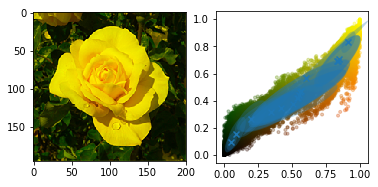

In [19]:
plt.subplot(121)
plt.imshow(img)

plt.subplot(122)
plt.scatter(im_flat_2D[:,0], im_flat_2D[:,1], c=im_flat, marker='.', edgecolors='face', alpha=0.3)
plt.scatter(centers[:,0], centers[:,1], marker='x')
plt.axis('square')

for mean, cov in zip(centers, sigmas):
    make_ellipse(mean, cov, plt.gca(), edgecolor='none', alpha=0.3)
None

## Gaussian mixtures in sklearn

The Gaussian mixtures are implemented in many popular toolboxes, notably in `sklearn`. 

In [24]:
from sklearn import mixture

In [25]:
gmm = mixture.GMM(n_components=16, covariance_type='full', min_covar=1e-3)
gmm.fit(im_flat_2D)

/pio/os/anaconda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/pio/os/anaconda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/pio/os/anaconda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/pio/os/anaconda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarn

GMM(covariance_type='full', init_params='wmc', min_covar=0.001,
  n_components=16, n_init=1, n_iter=100, params='wmc', random_state=None,
  tol=0.001, verbose=0)

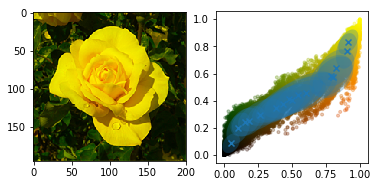

In [26]:
plt.subplot(121)
plt.imshow(img)

plt.subplot(122)
plt.scatter(im_flat_2D[:,0], im_flat_2D[:,1], c=im_flat, marker='.', edgecolors='face', alpha=0.3)
plt.scatter(gmm.means_[:,0], gmm.means_[:,1], marker='x')
plt.axis('square')

for mean, cov in zip(gmm.means_, gmm.covars_):
    make_ellipse(mean, cov, plt.gca(), edgecolor='none', alpha=0.3)
None

In [27]:
import sklearn
sklearn.__version__

'0.19.0'